#A: Do not change below cell, just run it

In [1]:
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
!wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

!tar xvf VOCtrainval_06-Nov-2007.tar
!tar xvf VOCtest_06-Nov-2007.tar

!rm VOCtrainval_06-Nov-2007.tar
!rm VOCtest_06-Nov-2007.tar

!rm -r /content/VOCdevkit/VOC2007/Annotations
!rm -r /content/VOCdevkit/VOC2007/ImageSets
!rm -r /content/VOCdevkit/VOC2007/SegmentationClass/
!rm -r /content/VOCdevkit/VOC2007/SegmentationObject

!gdown --id 1ZU2cim1iw-o3SWtf2XLxYOGJQv6GRC-v
!gdown --id 1HLhuo0Gw3fE_l320AwYYDcUVu9_jDQCq
!gdown --id 10ZYfoqBziUxvS4yBtJtUrxXEYxZFnZMk

Streaming output truncated to the last 5000 lines.
VOCdevkit/VOC2007/JPEGImages/000749.jpg
VOCdevkit/VOC2007/JPEGImages/000751.jpg
VOCdevkit/VOC2007/JPEGImages/000757.jpg
VOCdevkit/VOC2007/JPEGImages/000758.jpg
VOCdevkit/VOC2007/JPEGImages/000759.jpg
VOCdevkit/VOC2007/JPEGImages/000762.jpg
VOCdevkit/VOC2007/JPEGImages/000765.jpg
VOCdevkit/VOC2007/JPEGImages/000766.jpg
VOCdevkit/VOC2007/JPEGImages/000769.jpg
VOCdevkit/VOC2007/JPEGImages/000773.jpg
VOCdevkit/VOC2007/JPEGImages/000775.jpg
VOCdevkit/VOC2007/JPEGImages/000778.jpg
VOCdevkit/VOC2007/JPEGImages/000779.jpg
VOCdevkit/VOC2007/JPEGImages/000781.jpg
VOCdevkit/VOC2007/JPEGImages/000783.jpg
VOCdevkit/VOC2007/JPEGImages/000784.jpg
VOCdevkit/VOC2007/JPEGImages/000785.jpg
VOCdevkit/VOC2007/JPEGImages/000788.jpg
VOCdevkit/VOC2007/JPEGImages/000789.jpg
VOCdevkit/VOC2007/JPEGImages/000790.jpg
VOCdevkit/VOC2007/JPEGImages/000792.jpg
VOCdevkit/VOC2007/JPEGImages/000795.jpg
VOCdevkit/VOC2007/JPEGImages/000798.jpg
VOCdevkit/VOC2007/JPEGImages/

Format of data :

path bounding box for object class bounding box of another object in this image class........

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}

#B: implement YOLO from scratch, train and Test

The input is a (448, 448, 3) image and the output is a (7, 7, 30) tensor. The output is based on S x S x (B * 5 +C).

S X S is the number of grids B is the number of bounding boxes per grid C is the number of predictions per grid

After FC layer you should be reshape output soyou need to define a custom layer so you can use [this link](https://keras.io/guides/making_new_layers_and_models_via_subclassing/) for definning cusom layer

you can use below links:

[link1](https://www.youtube.com/watch?v=ag3DLKsl2vk)

[link2](https://www.youtube.com/watch?v=2hAiJe8ITsE)

In [2]:
import argparse
import xml.etree.ElementTree as ET
import os

parser = argparse.ArgumentParser(description='Build Annotations.')
parser.add_argument('dir', default='..', help='Annotations.')

sets = [('2007', 'train'), ('2007', 'val'), ('2007', 'test')]

classes_num = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5,
               'car': 6, 'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11,
               'horse': 12, 'motorbike': 13, 'person': 14, 'pottedplant': 15, 'sheep': 16,
               'sofa': 17, 'train': 18, 'tvmonitor': 19}


def convert_annotation(year, image_id, f):
    in_file = os.path.join('VOCdevkit/VOC%s/Annotations/%s.xml' % (year, image_id))
    tree = ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = obj.find('difficult').text
        cls = obj.find('name').text
        classes = list(classes_num.keys())
        if cls not in classes or int(difficult) == 1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(xmlbox.find('xmin').text), int(xmlbox.find('ymin').text),
             int(xmlbox.find('xmax').text), int(xmlbox.find('ymax').text))
        f.write(' ' + ','.join([str(a) for a in b]) + ',' + str(cls_id))


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
for year, image_set in sets:
  print(year, image_set)
  with open(os.path.join('VOCdevkit/VOC%s/ImageSets/Main/%s.txt' % (year, image_set)), 'r') as f:
      image_ids = f.read().strip().split()
  with open(os.path.join("VOCdevkit", '%s_%s.txt' % (year, image_set)), 'w') as f:
      for image_id in image_ids:
          f.write('%s/VOC%s/JPEGImages/%s.jpg' % ("VOCdevkit", year, image_id))
          convert_annotation(year, image_id, f)
          f.write('\n')


In [10]:
import cv2 as cv
import numpy as np

def read(image_path, label):
    image = cv.imread(image_path)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    image_h, image_w = image.shape[0:2]
    image = cv.resize(image, (448, 448))
    image = image / 255.

    label_matrix = np.zeros([7, 7, 30])
    for l in label:
        l = l.split(',')
        l = np.array(l, dtype=np.int)
        xmin = l[0]
        ymin = l[1]
        xmax = l[2]
        ymax = l[3]
        cls = l[4]
        x = (xmin + xmax) / 2 / image_w
        y = (ymin + ymax) / 2 / image_h
        w = (xmax - xmin) / image_w
        h = (ymax - ymin) / image_h
        loc = [7 * x, 7 * y]
        loc_i = int(loc[1])
        loc_j = int(loc[0])
        y = loc[1] - loc_i
        x = loc[0] - loc_j

        if label_matrix[loc_i, loc_j, 24] == 0:
            label_matrix[loc_i, loc_j, cls] = 1
            label_matrix[loc_i, loc_j, 20:24] = [x, y, w, h]
            label_matrix[loc_i, loc_j, 24] = 1  # response

    return image, label_matrix

In [11]:
from tensorflow import keras

class My_Custom_Generator(keras.utils.Sequence) :
  
  def __init__(self, images, labels, batch_size) :
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.images) / float(self.batch_size))).astype(np.int)
  
  
  def __getitem__(self, idx) :
    batch_x = self.images[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

    train_image = []
    train_label = []

    for i in range(0, len(batch_x)):
      img_path = batch_x[i]
      label = batch_y[i]
      image, label_matrix = read(img_path, label)
      train_image.append(image)
      train_label.append(label_matrix)
    return np.array(train_image), np.array(train_label)


In [13]:
train_datasets = []
val_datasets = []

with open(os.path.join(".", '2007_train.txt'), 'r') as f:
    train_datasets = train_datasets + f.readlines()
with open(os.path.join(".", '2007_val.txt'), 'r') as f:
    val_datasets = val_datasets + f.readlines()

X_train = []
Y_train = []

X_val = []
Y_val = []

for item in train_datasets:
  item = item.replace("\n", "").split(" ")
  X_train.append(item[0])
  arr = []
  for i in range(1, len(item)):
    arr.append(item[i])
  Y_train.append(arr)

for item in val_datasets:
  item = item.replace("\n", "").split(" ")
  X_val.append(item[0])
  arr = []
  for i in range(1, len(item)):
    arr.append(item[i])
  Y_val.append(arr)

In [15]:
batch_size = 4
my_training_batch_generator = My_Custom_Generator(X_train, Y_train, batch_size)

my_validation_batch_generator = My_Custom_Generator(X_val, Y_val, batch_size)

x_train, y_train = my_training_batch_generator.__getitem__(0)
x_val, y_val = my_training_batch_generator.__getitem__(0)
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

(4, 448, 448, 3)
(4, 7, 7, 30)
(4, 448, 448, 3)
(4, 7, 7, 30)


# Define a custom output layer

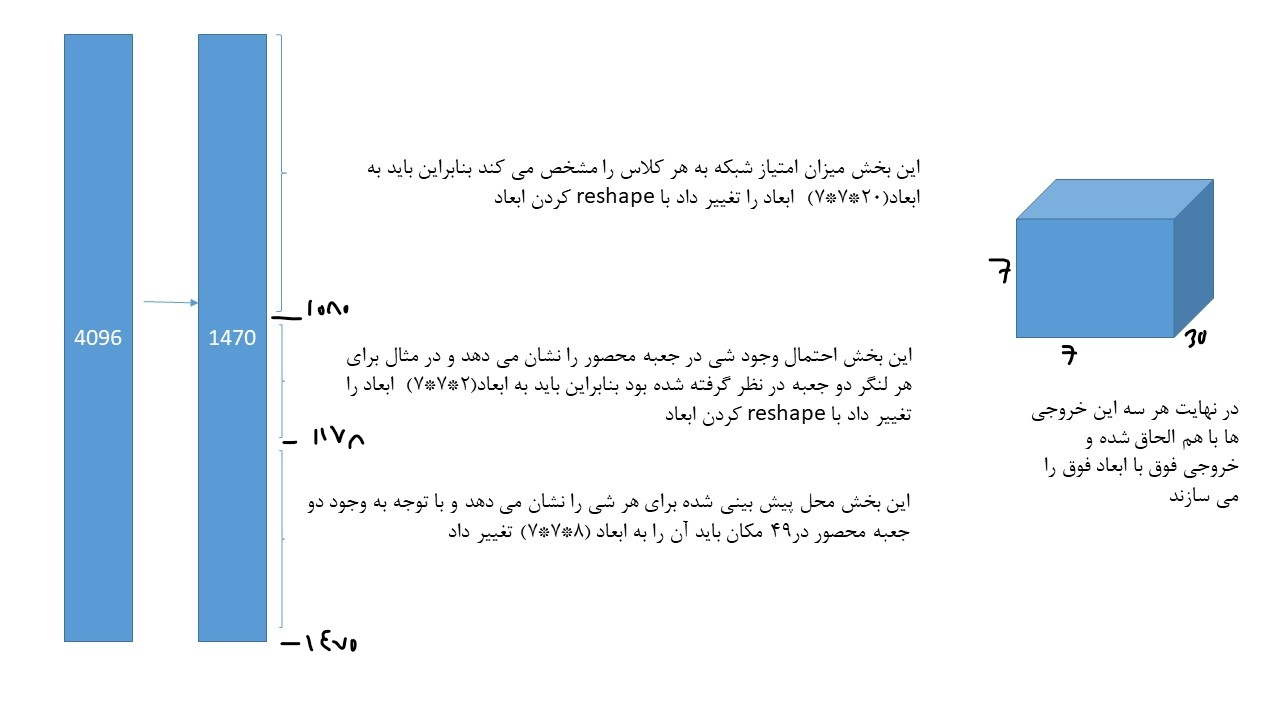

In [17]:
from tensorflow import keras
import keras.backend as K
import tensorflow as tf


class Yolo_Reshape(tf.keras.layers.Layer):
  def __init__(self, target_shape):
    super(Yolo_Reshape, self).__init__()
    self.target_shape = tuple(target_shape)

  def get_config(self):
    config = super().get_config().copy()
    config.update({
        'target_shape': self.target_shape
    })
    return config

  def call(self, input):
    # grids 7x7
    S = [self.target_shape[0], self.target_shape[1]]
    # classes
    C = 20
    # no of bounding boxes per grid
    B = 2

    idx1 = S[0] * S[1] * C
    idx2 = idx1 + S[0] * S[1] * B
    
    # class probabilities
    class_probs = K.reshape(input[:, :idx1], (K.shape(input)[0],) + tuple([S[0], S[1], C]))
    class_probs = K.softmax(class_probs)

    #confidence
    confs = K.reshape(input[:, idx1:idx2], (K.shape(input)[0],) + tuple([S[0], S[1], B]))
    confs = K.sigmoid(confs)

    # boxes
    boxes = K.reshape(input[:, idx2:], (K.shape(input)[0],) + tuple([S[0], S[1], B * 4]))
    boxes = K.sigmoid(boxes)

    outputs = K.concatenate([class_probs, confs, boxes])
    return outputs

# Defining the YOLO model

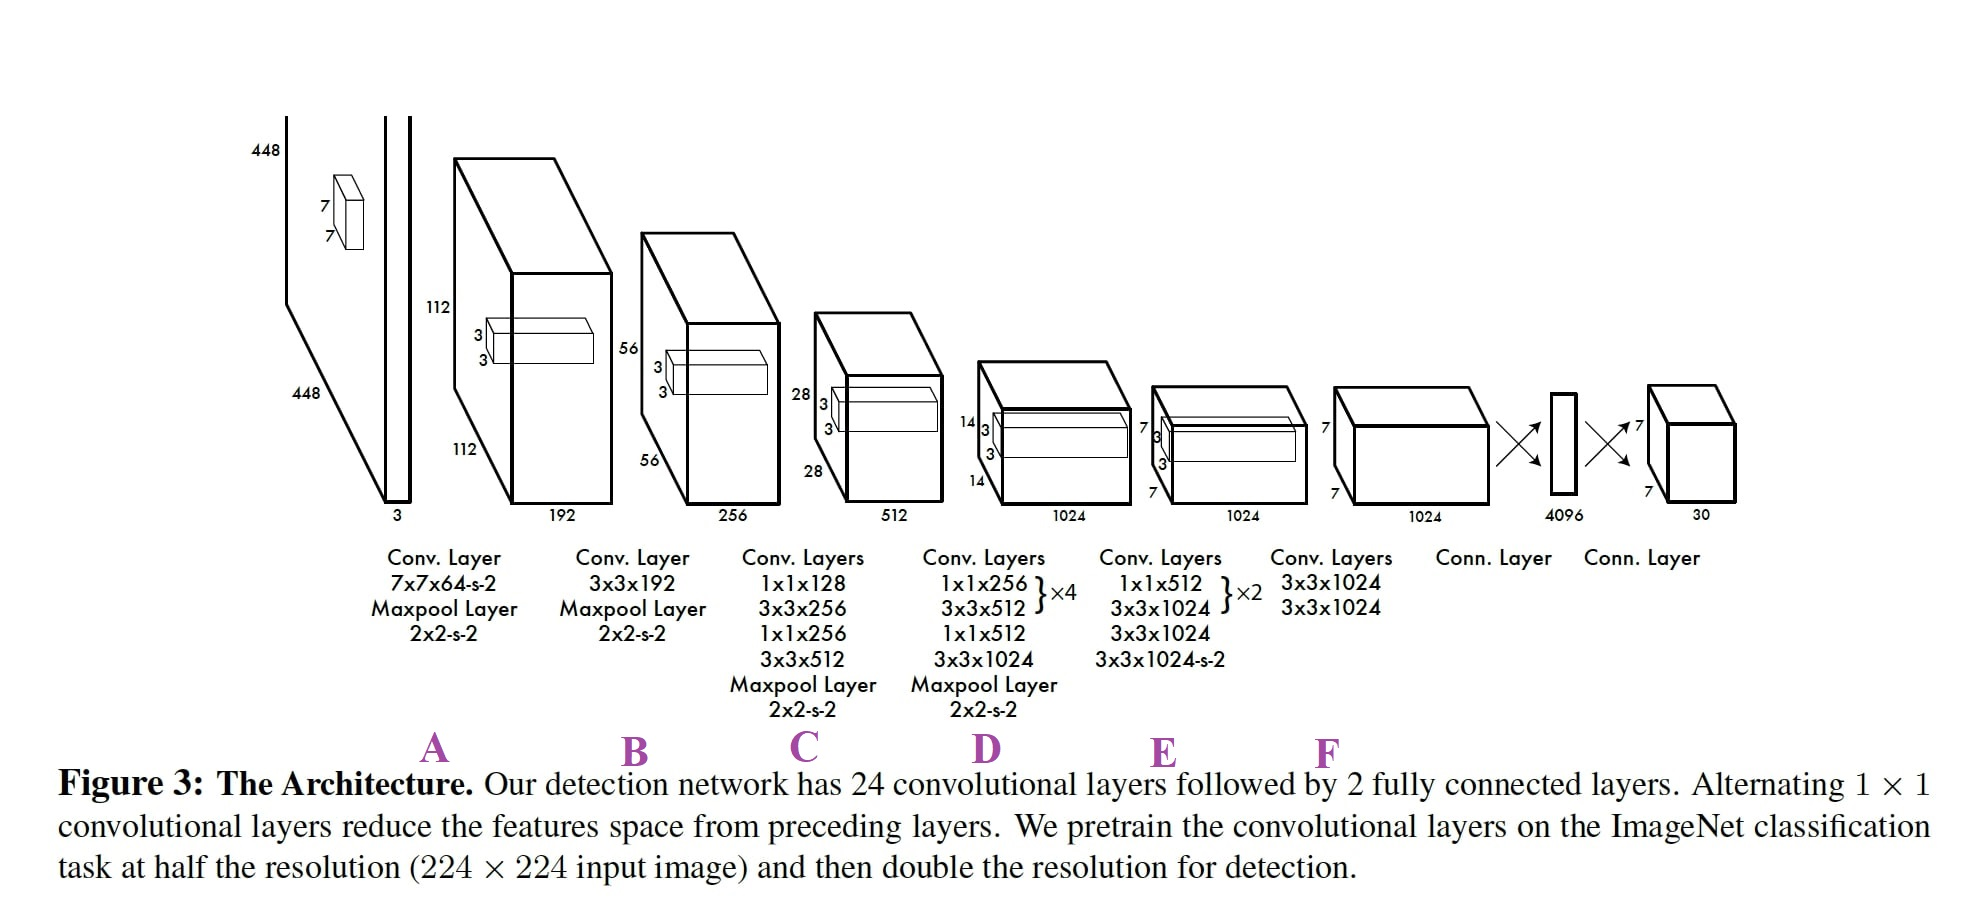

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Flatten, Reshape
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.regularizers import l2

lrelu = tf.keras.layers.LeakyReLU(alpha=0.1)

nb_boxes=1
grid_w=7
grid_h=7
cell_w=64
cell_h=64
img_w=grid_w*cell_w
img_h=grid_h*cell_h

model = Sequential()

# A
model.add(Conv2D(filters=64, kernel_size= (7, 7), strides=(1, 1), input_shape =(img_h, img_w, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# B
model.add(Conv2D(filters=192, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# C
model.add(Conv2D(filters=128, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# D
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=256, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2), padding = 'same'))

# E
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=512, kernel_size= (1, 1), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), padding = 'same', activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), strides=(2, 2), padding = 'same'))

# F
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))
model.add(Conv2D(filters=1024, kernel_size= (3, 3), activation=lrelu, kernel_regularizer=l2(5e-4)))


model.add(Flatten())
model.add(Dense(512))
model.add(Dense(1024))
model.add(Dropout(0.5))
model.add(Dense(1470, activation='sigmoid'))
model.add(Yolo_Reshape(target_shape=(7,7,30)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 448, 448, 64)      9472      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 224, 224, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 192)     110784    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 112, 112, 192)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 112, 112, 128)     24704     
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 256)     2

# Define a custom learning rate scheduler

In [19]:
from tensorflow import keras

class CustomLearningRateScheduler(keras.callbacks.Callback):
    """Learning rate scheduler which sets the learning rate according to schedule.

  Arguments:
      schedule: a function that takes an epoch index
          (integer, indexed from 0) and current learning rate
          as inputs and returns a new learning rate as output (float).
  """

    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule

    def on_epoch_begin(self, epoch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        # Get the current learning rate from model's optimizer.
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        # Call schedule function to get the scheduled learning rate.
        scheduled_lr = self.schedule(epoch, lr)
        # Set the value back to the optimizer before this epoch starts
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nEpoch %05d: Learning rate is %6.4f." % (epoch, scheduled_lr))


LR_SCHEDULE = [
    # (epoch to start, learning rate) tuples
    (0, 0.01),
    (75, 0.001),
    (105, 0.0001),
]


def lr_schedule(epoch, lr):
    """Helper function to retrieve the scheduled learning rate based on epoch."""
    if epoch < LR_SCHEDULE[0][0] or epoch > LR_SCHEDULE[-1][0]:
        return lr
    for i in range(len(LR_SCHEDULE)):
        if epoch == LR_SCHEDULE[i][0]:
            return LR_SCHEDULE[i][1]
    return lr


# Add a callback for saving the weights

In [21]:
#defining a function to save the weights of best model
from tensorflow.keras.callbacks import ModelCheckpoint

mcp_save = ModelCheckpoint('weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model

In [24]:
from tensorflow import keras

model.compile(loss=keras.losses.MeanSquaredError() ,optimizer='adam')

# Train the model

In [23]:
model.fit(x=my_training_batch_generator,
          steps_per_epoch = int(len(X_train) // batch_size),
          epochs = 5,
          verbose = 1,
          workers= 4,
          validation_data = my_validation_batch_generator,
          validation_steps = int(len(X_val) // batch_size),
           callbacks=[
              CustomLearningRateScheduler(lr_schedule),
              mcp_save
          ])


Epoch 00000: Learning rate is 0.0100.
Epoch 1/5
625/625 [==============================] - 906s 1s/step - loss: 103.4411 - val_loss: 110.1459

Epoch 00001: Learning rate is 0.0100.
Epoch 2/5
625/625 [==============================] - 881s 1s/step - loss: 77.3885 - val_loss: 59.5564

Epoch 00002: Learning rate is 0.0100.
Epoch 3/5
625/625 [==============================] - 876s 1s/step - loss: 258.0747 - val_loss: 162.8157

Epoch 00003: Learning rate is 0.0100.
Epoch 4/5
625/625 [==============================] - 877s 1s/step - loss: 130.3034 - val_loss: 108.4808

Epoch 00004: Learning rate is 0.0100.
Epoch 5/5
625/625 [==============================] - 877s 1s/step - loss: 97.4749 - val_loss: 89.7858


#C: preferential

In [ ]:
#اhint : https://github.com/AlexeyAB/darknet
#hint : https://colab.research.google.com/drive/12QusaaRj_lUwCGDvQNfICpa7kA7_a2dE#scrollTo=ikgv38AdKldo
#hint : https://medium.com/analytics-vidhya/train-a-custom-yolov4-object-detector-using-google-colab-61a659d4868